In [1941]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [1942]:
horizon = 30
number_days = 100

# Define the window sizes for the moving averages
short_window = 30  # Short-term moving average
long_window = 60   # Long-term moving average

predicted_value_threshold = 5
buy_cutoff = 5
sell_cutoff = -4


In [1943]:
# Load the CSV file into a DataFrame
file_path_1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_2010_2020.csv' # Daily technical data (CRSP)
file_path_2 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_q_data_2010_2020.csv' # Fundamental data (Compustat)
file_path_3 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_quarterly_ratiodata_2010_2020.csv' # Fundamental ratios (Compustat)

df1 = pd.read_csv(file_path_1)
df2 = pd.read_csv(file_path_2)
df3 = pd.read_csv(file_path_3)

#Convert date columns to datetime format
df1['date'] = pd.to_datetime(df1['date'])  # CRSP daily data
df2['datadate'] = pd.to_datetime(df2['datadate'])  # Fundamental data
df3['qdate'] = pd.to_datetime(df3['qdate'])  # Financial ratios data

print(df2.head())

   gvkey   datadate  fyearq  fqtr indfmt consol popsrc datafmt  tic curcdq  \
0   4503 2010-03-31    2010     1   INDL      C      D     STD  XOM    USD   
1   4503 2010-06-30    2010     2   INDL      C      D     STD  XOM    USD   
2   4503 2010-09-30    2010     3   INDL      C      D     STD  XOM    USD   
3   4503 2010-12-31    2010     4   INDL      C      D     STD  XOM    USD   
4   4503 2011-03-31    2011     1   INDL      C      D     STD  XOM    USD   

  datacqtr datafqtr  epsfxq       ltq      niq     revtq    capxy costat  
0   2010Q1   2010Q1    1.33  125082.0   6300.0   80222.0   5756.0      A  
1   2010Q2   2010Q2    1.60  145701.0   7560.0   82747.0  11400.0      A  
2   2010Q3   2010Q3    1.44  149394.0   7350.0   85181.0  19201.0      A  
3   2010Q4   2010Q4    1.85  149831.0   9250.0   93428.0  26871.0      A  
4   2011Q1   2011Q1    2.14  162002.0  10650.0  101335.0   7051.0      A  


In [1944]:
# QUARTERLY PERCENTAGE CHANGES

# Make a copy of df2 to avoid modifying the original data
df2_pct = df2.copy()

# Identify numeric columns that should be converted to percentage changes
# Exclude non-numeric columns such as 'gvkey', 'datadate', 'fyearq', 'fqtr', 'indfmt', 'consol', 'popsrc', 'datafmt', 'tic', 'curcdq', 'datacqtr', 'datafqtr', 'costat'
columns_to_change = ['epsfxq', 'ltq', 'niq', 'revtq', 'capxy']
# Apply pct_change to each selected column and multiply by 100 to express as percentage
df2_pct[columns_to_change] = df2[columns_to_change].pct_change() * 100

# Sort by qdate and public_date to ensure the most recent public_date comes last
df3_sorted = df3.sort_values(by=['qdate', 'public_date'])
# Drop duplicates to keep only the latest public_date for each qdate
df3_latest = df3_sorted.drop_duplicates(subset='qdate', keep='last')

# Make a copy to avoid modifying the original df3_latest
df3_latest_pct = df3_latest.copy()

# Select columns to calculate percentage change, excluding identifier and date columns
columns_to_change = ['npm', 'de_ratio', 'curr_ratio', 'ptb'] # Apply pct_change to each selected column and multiply by 100 to express as percentage
df3_latest_pct[columns_to_change] = df3_latest[columns_to_change].pct_change() * 100

print(df3_latest_pct.head())

    permno       adate      qdate public_date        npm  de_ratio  \
0    11850  2008-12-31 2009-09-30  2010-01-31        NaN       NaN   
3    11850  2009-12-31 2009-12-31  2010-04-30 -10.256410  2.301055   
6    11850  2009-12-31 2010-03-31  2010-07-31   0.000000  1.593252   
9    11850  2009-12-31 2010-06-30  2010-10-31  11.428571 -0.830258   
12   11850  2009-12-31 2010-09-30  2011-01-31   6.410256 -1.488372   

    curr_ratio        ptb TICKER  
0          NaN        NaN    XOM  
3   -15.120000   1.926370    XOM  
6     2.827521  -6.299874    XOM  
9    -1.741522 -13.850291    XOM  
12   -1.679104  17.377732    XOM  


In [1945]:
# First merge daily technical data (df1) with fundamental data (df2)
# Merge on the nearest quarter date for Exxon
df_combined_1_2 = pd.merge_asof(
    df1,  # Daily data sorted by date
    df2,  # Fundamental data sorted by quarterly date
    left_on='date', right_on='datadate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

# Now merge with the cleaned financial ratios (df3_latest)
df_combined_all = pd.merge_asof(
    df_combined_1_2.sort_values('date'),  # Combined data sorted by date
    df3_latest_pct.sort_values('qdate'),  # Financial ratios sorted by quarterly date
    left_on='date', right_on='qdate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

# Display the first few rows of the final combined dataset
print(df_combined_all.head())

   PERMNO       date TICKER_x   BIDLO  ASKHI    PRC       VOL       RET  \
0   11850 2010-01-04      XOM  68.190  69.26  69.15  27811300  0.014078   
1   11850 2010-01-05      XOM  68.800  69.45  69.42  30178600  0.003905   
2   11850 2010-01-06      XOM  69.340  70.60  70.02  35047500  0.008643   
3   11850 2010-01-07      XOM  69.415  70.06  69.80  27194100 -0.003142   
4   11850 2010-01-08      XOM  69.220  69.75  69.52  24899500 -0.004012   

   OPENPRC  gvkey  ... costat  permno       adate      qdate public_date  \
0    68.72    NaN  ...    NaN   11850  2009-12-31 2009-12-31  2010-04-30   
1    69.19    NaN  ...    NaN   11850  2009-12-31 2009-12-31  2010-04-30   
2    69.45    NaN  ...    NaN   11850  2009-12-31 2009-12-31  2010-04-30   
3    69.90    NaN  ...    NaN   11850  2009-12-31 2009-12-31  2010-04-30   
4    69.69    NaN  ...    NaN   11850  2009-12-31 2009-12-31  2010-04-30   

        npm  de_ratio curr_ratio      ptb TICKER_y  
0 -10.25641  2.301055     -15.12  1.926

In [1946]:
# Filter the DataFrame to remove unnecessary/repeated collumns
columns_to_keep = [
    'date', 
    'PRC', 'VOL', 'RET', 
    'epsfxq', 'ltq', 'niq', 'revtq', 
    'capxy', 'npm', 'de_ratio', 'curr_ratio', 'ptb'
]
df_filtered = df_combined_all[columns_to_keep]

# Define new names for columns to make them more understandable
column_renames = {
    'date': 'Date', 
    'PRC': 'Price', 
    'VOL': 'Volume', 
    'RET': 'Return',
    'epsfxq': 'Earnings_Per_Share', 
    'ltq': 'Long_Term_Debt', 
    'niq': 'Net_Income', 
    'revtq': 'Revenue', 
    'capxy': 'Capital_Expenditure', 
    'npm': 'Net_Profit_Margin', 
    'de_ratio': 'Debt_Equity_Ratio', 
    'curr_ratio': 'Current_Ratio', 
    'ptb': 'Price_To_Book_Ratio'
}

# Apply the filter and rename the columns
df_filtered = df_combined_all[columns_to_keep].rename(columns=column_renames)

# Calculate the percentage change in price over the time horizon
df_filtered['Horizon_Percent_Change'] = (
    (df_filtered['Price'].shift(-1 * horizon) - df_filtered['Price']) / df_filtered['Price'] * 100
)

# Move the 'Price' column to the end of the DataFrame
price_col = df_filtered.pop('Price')
df_filtered['Price'] = price_col

# Display the first few rows of the renamed DataFrame
print(df_filtered.head())


        Date    Volume    Return  Earnings_Per_Share  Long_Term_Debt  \
0 2010-01-04  27811300  0.014078                 NaN             NaN   
1 2010-01-05  30178600  0.003905                 NaN             NaN   
2 2010-01-06  35047500  0.008643                 NaN             NaN   
3 2010-01-07  27194100 -0.003142                 NaN             NaN   
4 2010-01-08  24899500 -0.004012                 NaN             NaN   

   Net_Income  Revenue  Capital_Expenditure  Net_Profit_Margin  \
0         NaN      NaN                  NaN          -10.25641   
1         NaN      NaN                  NaN          -10.25641   
2         NaN      NaN                  NaN          -10.25641   
3         NaN      NaN                  NaN          -10.25641   
4         NaN      NaN                  NaN          -10.25641   

   Debt_Equity_Ratio  Current_Ratio  Price_To_Book_Ratio  \
0           2.301055         -15.12              1.92637   
1           2.301055         -15.12              1

In [1947]:


# Calculate moving averages and add them as new columns
df_filtered['Short_MA'] = df_filtered['Price'].rolling(window=short_window, min_periods=1).mean()
df_filtered['Long_MA'] = df_filtered['Price'].rolling(window=long_window, min_periods=1).mean()

print(df_filtered.head())

        Date    Volume    Return  Earnings_Per_Share  Long_Term_Debt  \
0 2010-01-04  27811300  0.014078                 NaN             NaN   
1 2010-01-05  30178600  0.003905                 NaN             NaN   
2 2010-01-06  35047500  0.008643                 NaN             NaN   
3 2010-01-07  27194100 -0.003142                 NaN             NaN   
4 2010-01-08  24899500 -0.004012                 NaN             NaN   

   Net_Income  Revenue  Capital_Expenditure  Net_Profit_Margin  \
0         NaN      NaN                  NaN          -10.25641   
1         NaN      NaN                  NaN          -10.25641   
2         NaN      NaN                  NaN          -10.25641   
3         NaN      NaN                  NaN          -10.25641   
4         NaN      NaN                  NaN          -10.25641   

   Debt_Equity_Ratio  Current_Ratio  Price_To_Book_Ratio  \
0           2.301055         -15.12              1.92637   
1           2.301055         -15.12              1

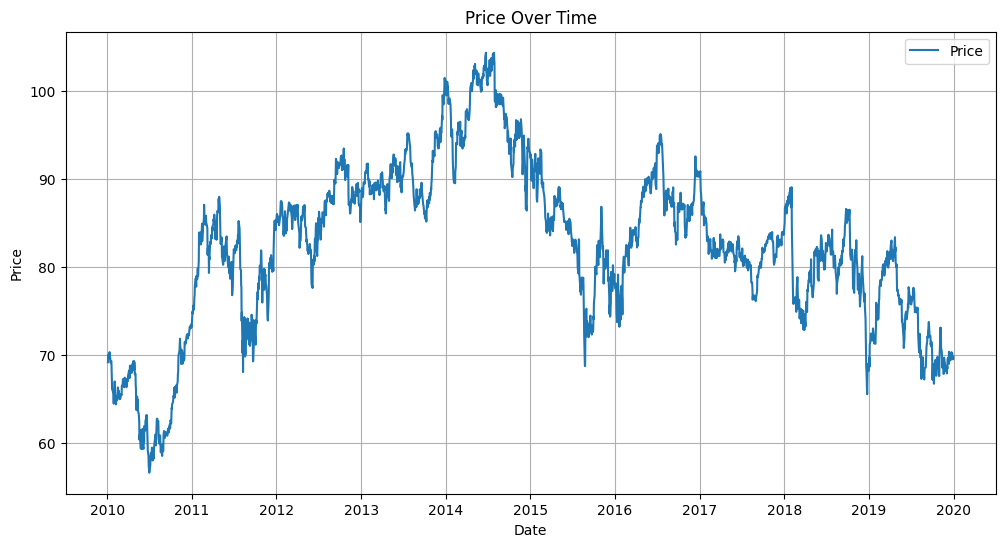

In [1948]:
import matplotlib.pyplot as plt

# Plot Price over time
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['Date'], df_filtered['Price'], label='Price', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [1949]:

# Calculate percentage change for 'Price' and replace it
#df_filtered['Price'] = df_filtered['Price'].pct_change() * 100

# Add price of previous days as features

for i in range(0, number_days):
    df_filtered[f'Price_Day_{i}'] = df_filtered['Price'].shift(i)

price_col = df_filtered.pop('Price')

df_filtered.dropna(inplace=True)

df = df_filtered

print(df.head(1))

         Date    Volume    Return  Earnings_Per_Share  Long_Term_Debt  \
99 2010-05-26  34031900 -0.006699                1.33        125082.0   

    Net_Income  Revenue  Capital_Expenditure  Net_Profit_Margin  \
99      6300.0  80222.0               5756.0                0.0   

    Debt_Equity_Ratio  ...  Price_Day_90  Price_Day_91  Price_Day_92  \
99           1.593252  ...         69.11         69.68         69.67   

    Price_Day_93  Price_Day_94  Price_Day_95  Price_Day_96  Price_Day_97  \
99         69.95          70.3         69.52          69.8         70.02   

    Price_Day_98  Price_Day_99  
99         69.42         69.15  

[1 rows x 115 columns]


/var/folders/2f/bmcm36r135v_v27k0vz0w_dr0000gn/T/ipykernel_16819/2803852500.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filtered[f'Price_Day_{i}'] = df_filtered['Price'].shift(i)
/var/folders/2f/bmcm36r135v_v27k0vz0w_dr0000gn/T/ipykernel_16819/2803852500.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filtered[f'Price_Day_{i}'] = df_filtered['Price'].shift(i)
/var/folders/2f/bmcm36r135v_v27k0vz0w_dr0000gn/T/ipykernel_16819/2803852500.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

In [1950]:
# SCALE FEATURES

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select the numeric columns to scale (all numeric columns except 'Date')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Remove 'Date' and 'Horizon' columns from scaling
numeric_columns.remove('Horizon_Percent_Change')  # Adjust the name to match your actual column name

# Scale the numeric columns
df_scaled = df.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Now df_scaled contains the scaled data

df = df_scaled

In [1951]:
# Prepare the features and target
fundamental_features = [
    'Earnings_Per_Share', 
    'Long_Term_Debt', 
    'Net_Income', 
    'Revenue', 
    'Capital_Expenditure', 
    'Net_Profit_Margin', 
    'Debt_Equity_Ratio', 
    'Current_Ratio',
    'Price_To_Book_Ratio'
]
    
features = df.drop(columns=(['Date','Horizon_Percent_Change']+fundamental_features))
features = df.drop(columns=['Date','Horizon_Percent_Change'])
target = df['Horizon_Percent_Change']

# Split the data: first into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
# Split the training + validation set further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Print the start and end dates of the entire dataset
start_date = df['Date'].min()
end_date = df['Date'].max()

print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")


Start Date: 2010-05-26 00:00:00
End Date: 2019-11-15 00:00:00


In [1952]:

# Ensure the DataFrame is sorted by date
df = df.sort_values(by='Date')

# Prepare the features and target
fundamental_features = [
    'Earnings_Per_Share', 
    'Long_Term_Debt', 
    'Net_Income', 
    'Revenue', 
    'Capital_Expenditure', 
    'Net_Profit_Margin', 
    'Debt_Equity_Ratio', 
    'Current_Ratio',
    'Price_To_Book_Ratio'
]

# Drop the date and target columns to create the features DataFrame
features = df.drop(columns=['Date', 'Horizon_Percent_Change'] + fundamental_features)
target = df['Horizon_Percent_Change']

# Define the cut-off dates for splitting
train_end_date = '2013-12-31'  # End of training set
val_end_date = '2014-08-31'      # End of validation set

# Split the data into training, validation, and test sets based on date
train_data = df[df['Date'] < train_end_date]
val_data = df[(df['Date'] >= train_end_date) & (df['Date'] < val_end_date)]
test_data = df[df['Date'] >= val_end_date]

# Create features and targets for each set
X_train = train_data.drop(columns=['Date', 'Horizon_Percent_Change'])
y_train = train_data['Horizon_Percent_Change']

X_val = val_data.drop(columns=['Date', 'Horizon_Percent_Change'])
y_val = val_data['Horizon_Percent_Change']

X_test = test_data.drop(columns=['Date', 'Horizon_Percent_Change'])
y_test = test_data['Horizon_Percent_Change']

In [1953]:
# Define the cut-off date for the test set
test_cutoff_date = '2014-08-31'  # Adjust this date as necessary

# Filter data for training and validation before the test cut-off
train_val_data = df[df['Date'] < test_cutoff_date]

# Split the data into features and target
X = train_val_data.drop(columns=['Date', 'Horizon_Percent_Change'])
y = train_val_data['Horizon_Percent_Change']

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, define the test set from the data after the test cutoff date
test_data = df[df['Date'] >= test_cutoff_date]

# Create features and targets for the test set
X_test = test_data.drop(columns=['Date', 'Horizon_Percent_Change'])
y_test = test_data['Horizon_Percent_Change']

In [1954]:
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and Evaluation on Training Set
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Predictions and Evaluation on Validation Set
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Predictions and Evaluation on Test Set
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Baseline Model: Mean Prediction
# Compute the mean of the training target
mean_train_target = y_train.mean()

# Use this mean as the prediction for all validation and test data points
y_val_baseline = np.full_like(y_val, fill_value=mean_train_target)
y_test_baseline = np.full_like(y_test, fill_value=mean_train_target)

# Baseline evaluation for validation set
val_baseline_rmse = np.sqrt(mean_squared_error(y_val, y_val_baseline))

# Baseline evaluation for test set
test_baseline_rmse = np.sqrt(mean_squared_error(y_test, y_test_baseline))

print(f"Baseline Validation RMSE: {val_baseline_rmse:.4f}")
print(f"Baseline Test RMSE: {test_baseline_rmse:.4f}")


# Calculate the percentage of correct sign predictions for the test set
correct_signs = np.sign(y_test) == np.sign(y_test_pred)
percentage_correct_signs = np.mean(correct_signs) * 100

# Print the percentage of correct sign predictions
print(f"Percentage of Correct Sign Predictions: {percentage_correct_signs:.2f}%")

Train RMSE: 3.7670
Validation RMSE: 4.5113
Test RMSE: 12.8353
Baseline Validation RMSE: 5.5838
Baseline Test RMSE: 6.2137
Percentage of Correct Sign Predictions: 46.53%


In [1955]:
# Initialize and train the Ridge Regression model with a specified alpha (regularization strength)
alpha = 0.4  # You can adjust this value to see how it affects performance
model = Ridge(alpha=alpha)
model.fit(X_train, y_train)

# Predictions and Evaluation on Training Set
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Predictions and Evaluation on Validation Set
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Predictions and Evaluation on Test Set
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Calculate the percentage of correct sign predictions for the test set
correct_signs = np.sign(y_test) == np.sign(y_test_pred)
percentage_correct_signs = np.mean(correct_signs) * 100

# Print the percentage of correct sign predictions
print(f"Percentage of Correct Sign Predictions: {percentage_correct_signs:.2f}%")

Train RMSE: 3.8101
Validation RMSE: 4.2734
Test RMSE: 11.1625
Percentage of Correct Sign Predictions: 46.31%


In [1956]:
# Initialize and train the Lasso Regression model with a specified alpha
alpha = 0.005  # You can adjust this value as needed
model = Lasso(alpha=alpha)
model.fit(X_train, y_train)

# Predictions and Evaluation on Training Set
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Predictions and Evaluation on Validation Set
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Predictions and Evaluation on Test Set
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Train RMSE: 3.8452
Validation RMSE: 4.2469
Test RMSE: 11.0961


In [1957]:
#SIGNS

# Calculate the percentage of true targets that are positive
total_positive_samples = np.sum(y_test > 0)
percentage_true_positive = np.mean(y_test > 0) * 100
# Print the percentage of true positive targets
print(f"Positive Targets: {total_positive_samples} ({percentage_true_positive:.2f}%)")

# Calculate the percentage of correct sign predictions for the test set
correct_signs = np.sign(y_test) == np.sign(y_test_pred)
percentage_correct_signs = np.mean(correct_signs) * 100
# Print the percentage of correct sign predictions
print(f"Percentage of Correct Sign Predictions: {percentage_correct_signs:.2f}%")
print("")

#BUYS

total_true_buys = np.sum(y_test > buy_cutoff)
percentage_true_buys = np.mean(y_test > buy_cutoff) * 100
# Print the percentage of true positive targets
print(f"{buy_cutoff}%+ Targets: {total_true_buys} ({percentage_true_buys:.2f}%)")

total_predicted_buys = np.sum(y_test_pred > buy_cutoff)
percentage_predicted_buys = np.mean(y_test_pred > buy_cutoff) * 100
# Print the percentage of true positive targets
print(f"{buy_cutoff}%+ Predictions: {total_predicted_buys} ({percentage_predicted_buys:.2f}%)")

# Identify cases where the predicted value is at least x
predicted_at_least_x = y_test_pred >= buy_cutoff
# Count how many of these cases have a true value that is at least zero
true_values_at_least_x = y_test >= buy_cutoff
# Calculate the number of cases where the predicted value is at least 5 and the true value is non-negative
correct_cases_count = np.sum(true_values_at_least_x[predicted_at_least_x])
total_cases_count = np.sum(predicted_at_least_x)
# Calculate the percentage
percentage_true_x = (correct_cases_count / total_cases_count * 100) if total_cases_count > 0 else 0
# Print the result
print(f"Percentage of {buy_cutoff}%+ Target when Predicted Value >= {buy_cutoff}%: {percentage_true_x:.2f}%")


# Count how many of these cases have a true value that is at least zero
true_values_non_negative = y_test >= 0
# Calculate the number of cases where the predicted value is at least 5 and the true value is non-negative
correct_cases_count = np.sum(true_values_non_negative[predicted_at_least_x])
total_cases_count = np.sum(predicted_at_least_x)
# Calculate the percentage
percentage_true_non_negative = (correct_cases_count / total_cases_count * 100) if total_cases_count > 0 else 0
# Print the result
print(f"Percentage of Positive Target when Predicted Value >= {buy_cutoff}%: {percentage_true_non_negative:.2f}%")
print("")

#SELLS 

total_true_sells = np.sum(y_test < sell_cutoff)
percentage_true_sells = np.mean(y_test < sell_cutoff) * 100
# Print the percentage of true positive targets
print(f"{sell_cutoff}% Targets: {total_true_sells} ({percentage_true_sells:.2f}%)")

total_predicted_sells = np.sum(y_test_pred < sell_cutoff)
percentage_predicted_sells = np.mean(y_test_pred < sell_cutoff) * 100
# Print the percentage of true positive targets
print(f"{sell_cutoff}% Predictions: {total_predicted_sells} ({percentage_predicted_sells:.2f}%)")

# Identify cases where the predicted value is at least x
predicted_at_least_x = y_test_pred <= sell_cutoff
# Count how many of these cases have a true value that is at least zero
true_values_at_least_x = y_test <= sell_cutoff
# Calculate the number of cases where the predicted value is at least 5 and the true value is non-negative
correct_cases_count = np.sum(true_values_at_least_x[predicted_at_least_x])
total_cases_count = np.sum(predicted_at_least_x)
# Calculate the percentage
percentage_true_x = (correct_cases_count / total_cases_count * 100) if total_cases_count > 0 else 0
# Print the result
print(f"Percentage of {sell_cutoff}% Target when Predicted Value <= {sell_cutoff}%: {percentage_true_x:.2f}%")


# Count how many of these cases have a true value that is at least zero
true_values_negative = y_test <= 0
# Calculate the number of cases where the predicted value is at least 5 and the true value is non-negative
correct_cases_count = np.sum(true_values_negative[predicted_at_least_x])
total_cases_count = np.sum(predicted_at_least_x)
# Calculate the percentage
percentage_true_non_negative = (correct_cases_count / total_cases_count * 100) if total_cases_count > 0 else 0
# Print the result
print(f"Percentage of Negative Target when Predicted Value <= {sell_cutoff}%: {percentage_true_non_negative:.2f}%")
print("")

Positive Targets: 598 (45.54%)
Percentage of Correct Sign Predictions: 46.15%

5%+ Targets: 234 (17.82%)
5%+ Predictions: 1003 (76.39%)
Percentage of 5%+ Target when Predicted Value >= 5%: 20.74%
Percentage of Positive Target when Predicted Value >= 5%: 49.25%

-4% Targets: 355 (27.04%)
-4% Predictions: 0 (0.00%)
Percentage of -4% Target when Predicted Value <= -4%: 0.00%
Percentage of Negative Target when Predicted Value <= -4%: 0.00%



In [1958]:
# Create a DataFrame for easier plotting and comparison
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred}, index=X_test.index)

# Filter the results for cases where the predicted value is >= 4 or <= -4
filtered_results = results[(results['Predicted'] >= 4) | (results['Predicted'] <= -4)]

# Print the filtered results
print(results.head(20))  # Display the first 20 cases that meet the criteria


        Actual  Predicted
1173 -8.061732   0.855309
1174 -8.969832   0.498636
1175 -7.889386   1.103735
1176 -8.110014   0.788339
1177 -6.136852   2.211015
1178 -3.840230   2.325270
1179 -3.801260   2.599962
1180 -3.009379   2.301647
1181 -1.346837   3.107673
1182 -2.679406   2.863749
1183 -2.391461   1.844377
1184 -2.564895   2.095741
1185 -2.235793   2.366476
1186 -0.422158   1.716722
1187 -1.325875   2.355293
1188 -1.572425   2.626471
1189 -0.782718   2.614252
1190  2.132626   3.725607
1191  1.215551   2.598700
1192  1.959123   3.417049
